In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from neuron import NeuronParam, SimpleNeuron
from synapse import Synapse
from encoding import RF_convolution, encode, RF_kernel
from parameter import TrainParam
from STDP import stdp


In [2]:
np.random.seed(1)
weight_seed = 

In [3]:
T = 150
dt = 1
t_pre = -20
t_post = 20


n1 = 16*16 # of neurons in layer 1
n2 = 3 # of neurons in layer 2

wmin=-1.2
wmax=2.
tau_pre = 10
tau_post = 10
A_pre = 0.3
A_post = 0.8

lr = 0.02

train_param = TrainParam(T = T,
                         dt = dt)
    
neuron_param = NeuronParam(t_refractory = 30,
                           V_rest = 0,
                           V_thr = 10,
                           V_min = -5,
                           leak = 0.75, 
                           record = True)

learning_rule = lambda x : stdp(x,
                                tau_pre = tau_pre, 
                                tau_post = tau_post, 
                                A_pre = A_pre, 
                                A_post = A_post)



In [4]:
timeline = np.arange(0,T+dt,dt)

layer = [SimpleNeuron(neuron_param) for _ in range(n2)]

synapse = Synapse(n1,layer)

synapse.random_initialize(0,wmax*0.5)

In [5]:
image = cv2.imread(f"data2/{0}.png",0)
image_ = RF_convolution(image,RF_kernel)
#image_ = image
input_spiketrain = encode(image_,train_param)
print(np.max(image_),np.min(image_))

1.375 -0.75


1.375


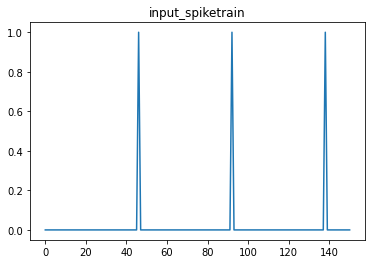

In [6]:
idx=151
print(image_.reshape(-1)[idx])
plt.plot(input_spiketrain[idx])
plt.title("input_spiketrain")
plt.show()

In [7]:
np.nonzero(image_.reshape(-1)>500)

(array([], dtype=int64),)

In [8]:
np.nonzero(input_spiketrain[idx])

(array([ 46,  92, 138]),)

In [9]:
91-45

46

In [10]:
learning_rule(3)

-0.5926545765453743

In [11]:
learn = True
inhibit = False
n_epoch = 3

epoch_output = []
n_winner = np.zeros((3,n2))
for epoch in tqdm(range(n_epoch)):
    outputs = []
    for num in range(3):



        image = cv2.imread(f"data2/{num}.png",0)
        image = RF_convolution(image,RF_kernel)
        input_spiketrain = encode(image,train_param)
        #adaptation = 300./np.max(np.sum(input_spiketrain,axis=0)) * 0.01
        adaptation = 1
        #var_thr_list = [13.333333,10.0,13.6666666]
        #for neuron in layer:
        #    neuron.V_thr = var_thr_list[num]
        #print(adaptation)
        

        synapse.reset()


        output_spiketrain = []
        for i,t in enumerate(timeline):
            input_spikes = input_spiketrain[:,i] # size = (n1, )
            output_spikes = synapse.run(input_spikes,t,adaptation) # size = (n2,)
            output_spiketrain.append(output_spikes)

            if learn:
                for j,s in enumerate(output_spikes):
                    if(s==1): #SPIKE
                        for delta_t in range(-dt-dt,t_pre-dt, -dt): #delta_t < 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for k in range(n1):
                                    if input_spiketrain[k,i+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[k,j]
                                        assert dw>0
                                        synapse.weight[k,j] += dw*(wmax-w)*lr*adaptation
                        for delta_t in range(dt+dt,t_post+dt,dt): #delta_t > 0
                            if 0 <= t+delta_t <= T:
                                tick = int(delta_t//dt)
                                for k in range(n1):
                                    if input_spiketrain[k,i+tick] == 1:
                                        dw = learning_rule(delta_t)
                                        w = synapse.weight[k,j]
                                        assert dw<0
                                        #print(dw)
                                        synapse.weight[k,j] += dw*(w-abs(wmin))*lr*adaptation

            #if inhibit and np.sum(output_spikes) > 0: #if spike occurs
            #    for i in range(n2):
            #        if output_spikes[i] == 0: # if i'th neuron did not spiked
            #            layer[i].inhibit() #inhibit i'th neuron
            if inhibit:
                tmp = np.arange(n2)
                np.random.shuffle(tmp)
                winner = -1
                for idx in tmp:
                    if output_spikes[idx] == 1:
                        winner = idx
                        break
                if winner >= 0:
                    for idx in range(n2):
                        if idx != winner:
                            layer[idx].inhibit()
                    n_winner[num,winner] += 1
                


        outputs.append(np.array(output_spiketrain).T)
    epoch_output.append(outputs)

100%|██████████| 3/3 [00:00<00:00,  9.73it/s]


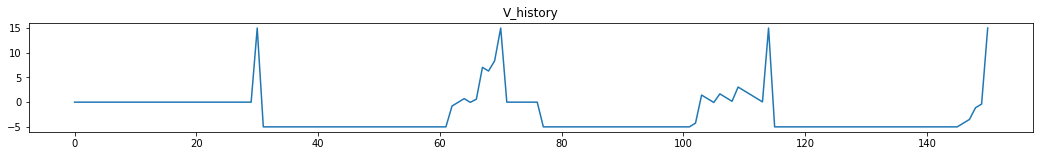

In [12]:
plt.figure(figsize=(18,2))
plt.plot(layer[1].V_history)
plt.title("V_history")
plt.show()

In [13]:
n_winner

array([[2., 2., 5.],
       [5., 5., 6.],
       [4., 5., 5.]])

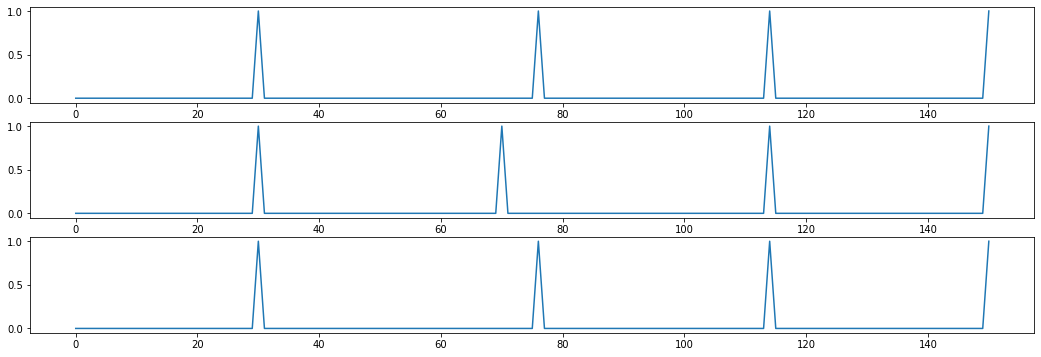

In [14]:
epoch = n_epoch
idx = 2
fig = plt.figure(figsize=(18,2*n2))
axes=[]
for i in range(n2):
    axes.append(fig.add_subplot(n2,1,i+1))
    axes[i].plot(epoch_output[epoch-1][idx][i,:])

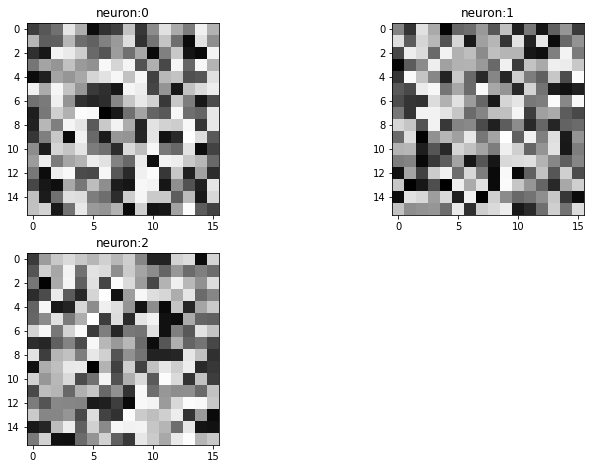

1.0405771016317464 0.019276748188320484


In [15]:
fig = plt.figure(figsize=(12,12))
axes = []
row = 3
col = n2//row + 1
max_ = np.max(synapse.weight)
min_ = np.min(synapse.weight)
for num in range(n2):
    learned_img = np.interp(synapse.weight[:,num].reshape(16,16),[min_,max_],[0,255])
    axes.append(fig.add_subplot(row,col,num+1))
    axes[num].imshow(learned_img,cmap='Greys')
    axes[num].set_title(f"neuron:{num}")

plt.show()

print(max_, min_)


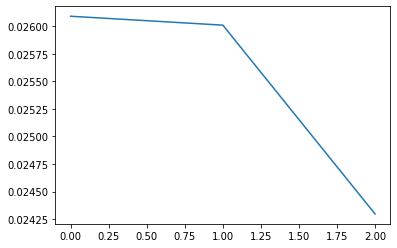

In [16]:
plt.plot(synapse.recent_activities)